# From Scratch MNIST Classification Using an Artificial Neural Network (ANN)

In [1]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
train_images = train_images.reshape(-1, 784).astype('float32') / 255.0
test_images = test_images.reshape(-1, 784).astype('float32') / 255.0

### Explanation: Loading and Preprocessing MNIST Data

**Reshape the Data:**
   - **`reshape(-1, 784)`**:
     - Reshapes each image from 28x28 to a flat 784-dimensional vector (`28 * 28 = 784`).
     - `-1` lets NumPy infer the correct number of samples from the dataset.
   - **`.astype('float32')`**:
     - Converts the pixel values to 32-bit floating-point numbers for better numerical precision during training.
   - **`/ 255.0`**:
     - Normalizes the pixel values to the range `[0, 1]` by dividing by the maximum pixel intensity (255).
     - Normalization helps the neural network converge faster during training by ensuring consistent data scaling.

In [4]:
train_images.shape

(60000, 784)

In [5]:
# One-hot encode labels
train_labels_one_hot = np.eye(10)[train_labels]
test_labels_one_hot = np.eye(10)[test_labels]

### Explanation: One-Hot Encoding Labels

1. **What Is One-Hot Encoding?**
   - One-hot encoding transforms categorical labels into binary vectors.
   - Example: The digit `3` becomes `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`.

2. **How It Works:**
   - `np.eye(10)` creates a 10x10 identity matrix:
     ```
     [[1, 0, 0, ..., 0],
      [0, 1, 0, ..., 0],
      [0, 0, 1, ..., 0],
      ...]
     ```
   - Indexing `np.eye(10)[train_labels]` selects the corresponding row from the identity matrix based on the label's value.

3. **Why Use It?**
   - One-hot encoding is essential for multi-class classification.
   - It allows the neural network's output to be compared directly with the one-hot labels when calculating loss using categorical cross-entropy.

In [6]:
# Split training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels_one_hot, test_size=0.2)

In [7]:
# Initialize parameters with He initialization
def initialize_parameters():
    parameters = {
        'W1': np.random.randn(256, 784) * np.sqrt(2. / 784),
        'b1': np.zeros((256, 1)),
        'W2': np.random.randn(128, 256) * np.sqrt(2. / 256),
        'b2': np.zeros((128, 1)),
        'W3': np.random.randn(10, 128) * np.sqrt(2. / 128),
        'b3': np.zeros((10, 1))
    }
    return parameters

### Explanation: Initializing Parameters with He Initialization

The function `initialize_parameters()` initializes weights and biases for a 3-layer neural network using **He initialization**.

---

### **Why He Initialization?**
- He initialization sets the weights using a scaled normal distribution.
- It helps avoid vanishing/exploding gradients, ensuring stable training.
- Formula:  
  $
  W = \text{np.random.randn}(n_{\text{out}}, n_{\text{in}}) \times \sqrt{\frac{2}{n_{\text{in}}}}
  $
  Where:
  - $(n_{\text{in}})$: Number of input units from the previous layer.
  - $(n_{\text{out}})$: Number of output units in the current layer.

---

1. **Layer 1 (Input to First Hidden Layer):**
   - `W1`: Weight matrix of shape **(256, 784)**.
   - `b1`: Bias vector of shape **(256, 1)** initialized to zeros.

2. **Layer 2 (Hidden Layer to Second Hidden Layer):**
   - `W2`: Weight matrix of shape **(128, 256)**.
   - `b2`: Bias vector of shape **(128, 1)** initialized to zeros.

3. **Layer 3 (Second Hidden Layer to Output Layer):**
   - `W3`: Weight matrix of shape **(10, 128)**.
   - `b3`: Bias vector of shape **(10, 1)** initialized to zeros.

---

### **Why Zero Bias Initialization?**
- Bias terms are initialized to zero because they don’t depend on input variance and are learned during training.

---

### **Why This Matters?**
- Proper initialization ensures:
  - Faster convergence.
  - Reduced risk of getting stuck in poor local minima.
  - Stable gradients during backpropagation.

In [8]:
# Activation functions
def relu(Z):
    return np.maximum(0, Z)

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def relu_derivative(Z):
    return Z > 0

In [9]:
# Forward propagation
def forward_propagation(X, parameters):
    Z1 = np.dot(parameters['W1'], X.T) + parameters['b1']
    A1 = relu(Z1)
    Z2 = np.dot(parameters['W2'], A1) + parameters['b2']
    A2 = relu(Z2)
    Z3 = np.dot(parameters['W3'], A2) + parameters['b3']
    A3 = softmax(Z3)
    cache = (Z1, A1, Z2, A2, Z3, A3)
    return A3, cache

### Explanation: Forward Propagation

The function `forward_propagation(X, parameters)` performs forward propagation through a 3-layer neural network. It computes the network's predictions by passing the input through the layers sequentially.

---

### **Step-by-Step Breakdown:**

#### 1. **Layer 1 (Input to First Hidden Layer):**
```python
Z1 = np.dot(parameters['W1'], X.T) + parameters['b1']
A1 = relu(Z1)
```
- **Z1:**  
  - Linear transformation:  
    $
    Z_1 = W_1 \cdot X^T + b_1
    $
  - Shape: **(256, Number of Samples)**

- **A1:**  
  - Activation using **ReLU**:  
    $
    A_1 = \text{ReLU}(Z_1) = \max(0, Z_1)
    $
  - This introduces non-linearity to the model.

---

#### 2. **Layer 2 (Hidden Layer to Next Hidden Layer):**
```python
Z2 = np.dot(parameters['W2'], A1) + parameters['b2']
A2 = relu(Z2)
```
- **Z2:**  
  - Linear transformation:  
    $
    Z_2 = W_2 \cdot A_1 + b_2
    $
  - Shape: **(128, Number of Samples)**

- **A2:**  
  - Activation using **ReLU**:  
    $
    A_2 = \text{ReLU}(Z_2)
    $

---

#### 3. **Layer 3 (Second Hidden Layer to Output Layer):**
```python
Z3 = np.dot(parameters['W3'], A2) + parameters['b3']
A3 = softmax(Z3)
```
- **Z3:**  
  - Linear transformation:  
    $
    Z_3 = W_3 \cdot A_2 + b_3
    $
  - Shape: **(10, Number of Samples)**

- **A3:**  
  - Activation using **Softmax**:  
    $
    A_3 = \text{Softmax}(Z_3) = \frac{e^{Z_3}}{\sum e^{Z_3}}
    $
  - This outputs probabilities for each of the 10 possible classes (digits 0-9).

---

### **Why Save to Cache?**
```python
cache = (Z1, A1, Z2, A2, Z3, A3)
```
- **Why Cache?**
  - Caching intermediate results (`Z1`, `A1`, `Z2`, `A2`, `Z3`, `A3`) simplifies the backward pass during backpropagation.

---

### **What Is Returned?**
```python
return A3, cache
```
- **A3:** The network’s predictions (output probabilities).
- **cache:** Cached results needed for backpropagation.

---

### **Summary:**
- Forward propagation computes activations and outputs layer by layer.
- It combines linear transformations (`Z`) and activations (`A`).
- It returns the predictions and intermediate results for learning through backpropagation.

In [10]:
# Backward propagation
def back_propagation(X, Y, parameters, cache):
    m = X.shape[0]
    Z1, A1, Z2, A2, Z3, A3 = cache

    dZ3 = A3
    dZ3[Y.argmax(axis=1), np.arange(m)] -= 1
    dW3 = np.dot(dZ3, A2.T) / m
    db3 = np.sum(dZ3, axis=1, keepdims=True) / m

    dA2 = np.dot(parameters['W3'].T, dZ3)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    dA1 = np.dot(parameters['W2'].T, dZ2)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(dZ1, X) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2, 'dW3': dW3, 'db3': db3}
    return grads

### Explanation: Backward Propagation

The function `back_propagation(X, Y, parameters, cache)` computes the gradients of the cost function with respect to the network parameters using the **chain rule**. These gradients are used to update the weights and biases during training.

---

### **Step-by-Step Breakdown:**

#### 1. **Extract Cached Values:**
```python
m = X.shape[0]
Z1, A1, Z2, A2, Z3, A3 = cache
```
- `m`: Number of training samples.
- The cached values from the forward pass are unpacked to avoid recomputation.

---

#### 2. **Output Layer Gradients:**
```python
dZ3 = A3
dZ3[Y.argmax(axis=1), np.arange(m)] -= 1
dW3 = np.dot(dZ3, A2.T) / m
db3 = np.sum(dZ3, axis=1, keepdims=True) / m
```
- **dZ3:** Error at the output layer:  
  $
  dZ_3 = A_3 - Y
  $
  This adjusts the predicted probabilities `A3` by subtracting the true labels `Y` using one-hot encoding.

- **dW3:** Gradient of the loss with respect to `W3`:  
  $
  dW_3 = \frac{1}{m} dZ_3 \cdot A_2^T
  $

- **db3:** Gradient of the loss with respect to `b3`:  
  $
  db_3 = \frac{1}{m} \sum dZ_3
  $

---

#### 3. **Second Hidden Layer Gradients:**
```python
dA2 = np.dot(parameters['W3'].T, dZ3)
dZ2 = dA2 * relu_derivative(Z2)
dW2 = np.dot(dZ2, A1.T) / m
db2 = np.sum(dZ2, axis=1, keepdims=True) / m
```
- **dA2:** Propagated error from the next layer:  
  $
  dA_2 = W_3^T \cdot dZ_3
  $

- **dZ2:** Applying ReLU derivative:  
  $
  dZ_2 = dA_2 \odot \text{ReLU}'(Z_2)
  $

- **dW2 and db2:** Weight and bias gradients for layer 2.

---

#### 4. **First Hidden Layer Gradients:**
```python
dA1 = np.dot(parameters['W2'].T, dZ2)
dZ1 = dA1 * relu_derivative(Z1)
dW1 = np.dot(dZ1, X) / m
db1 = np.sum(dZ1, axis=1, keepdims=True) / m
```
- **dA1:** Propagated error from the previous layer:  
  $
  dA_1 = W_2^T \cdot dZ_2
  $

- **dZ1:** Applying ReLU derivative:  
  \[
  dZ_1 = dA_1 \odot \text{ReLU}'(Z_1)
  \]

- **dW1 and db1:** Weight and bias gradients for layer 1.

---

### **Collect Gradients:**
```python
grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2, 'dW3': dW3, 'db3': db3}
```
- The computed gradients are stored in a dictionary `grads`.

---

### **What Is Returned?**
```python
return grads
```
- **Returns:** A dictionary containing all the computed gradients for use in parameter updates.

---

### **Why This Matters:**
- Backpropagation efficiently computes the gradients using the **chain rule**.
- These gradients enable the network to learn by adjusting its weights and biases through **gradient descent**.

In [9]:
# Update parameters with gradient descent
def update_parameters(parameters, grads, learning_rate):
    for key in parameters.keys():
        parameters[key] -= learning_rate * grads['d' + key]
    return parameters

### Explanation: Update Parameters with Gradient Descent

The function `update_parameters(parameters, grads, learning_rate)` adjusts the neural network's weights and biases using the computed gradients from backpropagation. This process follows the **gradient descent algorithm**.

---

### **How It Works:**

1. **Loop Through Each Parameter:**
   ```python
   for key in parameters.keys():
       parameters[key] -= learning_rate * grads['d' + key]
   ```
   - The function iterates through all the keys in the `parameters` dictionary, which contains:
     - `W1`, `b1` → First layer weights and biases.
     - `W2`, `b2` → Second layer weights and biases.
     - `W3`, `b3` → Third layer weights and biases.

2. **Gradient Descent Update Rule:**
   - For each parameter $( \theta )$, the update rule is:
     $
     \theta = \theta - \alpha \cdot \frac{\partial J}{\partial \theta}
     $
   - Where:
     - $( \theta )$: Current parameter (weights or biases).
     - $( \alpha )$: Learning rate (step size).
     - $( \frac{\partial J}{\partial \theta} )$: Gradient of the parameter from backpropagation.

3. **Specific Updates:**
   - **Weights Update:**
     ```python
     parameters['W1'] -= learning_rate * grads['dW1']
     parameters['W2'] -= learning_rate * grads['dW2']
     parameters['W3'] -= learning_rate * grads['dW3']
     ```
   - **Biases Update:**
     ```python
     parameters['b1'] -= learning_rate * grads['db1']
     parameters['b2'] -= learning_rate * grads['db2']
     parameters['b3'] -= learning_rate * grads['db3']
     ```

---

### **Why This Matters:**
- The weights and biases are updated using their corresponding gradients, moving the parameters **opposite** to the gradient direction (minimizing the cost).
- This process gradually reduces the loss and improves the model's performance.

---

### **Return Statement:**
```python
return parameters
```
- The function returns the updated parameters, which are used in the next training iteration.

---

### **Why It’s Important:**
- **Learning Rate Tuning:** A properly chosen learning rate ensures efficient training:
  - **Too Small:** Slow convergence.
  - **Too Large:** Risk of overshooting the minimum.
- **Efficient Updates:** This function keeps the update process clean and scalable for larger models.

In [10]:
# Predict function
def predict(X, parameters):
    Y_hat, _ = forward_propagation(X, parameters)
    return np.argmax(Y_hat, axis=0)

### Explanation: Predict Function

The function `predict(X, parameters)` makes predictions using the trained neural network by performing **forward propagation**.

---

### **How It Works:**

1. **Forward Propagation:**
   ```python
   Y_hat, _ = forward_propagation(X, parameters)
   ```
   - The input `X` is passed through the network using the `forward_propagation()` function.
   - `Y_hat` contains the predicted probabilities for each class (digits 0-9).
   - The cache (`_`) is not used here since backpropagation is not needed during inference.

---

2. **Select the Most Likely Class:**
   ```python
   return np.argmax(Y_hat, axis=0)
   ```
   - `np.argmax(Y_hat, axis=0)` selects the index of the maximum value along each column (sample).
   - Since `Y_hat` contains probabilities, the class with the highest probability is the predicted digit.

---

### **Example:**
Suppose `Y_hat` looks like this for a sample:
```python
Y_hat = [[0.1, 0.05], 
         [0.2, 0.1], 
         [0.7, 0.85]]
```
- `np.argmax(Y_hat, axis=0)` returns:
  ```
  [2, 2]
  ```
  Meaning the model predicts class `2` for both samples.

---

### **Why This Matters:**
- This function is essential for:
  - **Model Evaluation:** Calculating accuracy by comparing predicted labels with actual labels.
  - **Model Inference:** Making predictions on new data after training.

---

### Summary:
- Performs a forward pass through the network.
- Returns the predicted class labels for each input sample.
- Used during both validation and testing stages.

In [13]:
# Train the model
def model(X_train, Y_train, X_val, Y_val, learning_rate=0.001, epochs=10, batch_size=64):
    parameters = initialize_parameters()
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            Y_batch = Y_train[i:i+batch_size]
            Y_hat, cache = forward_propagation(X_batch, parameters)
            loss = -np.mean(np.sum(Y_batch * np.log(Y_hat.T + 1e-8), axis=1))
            grads = back_propagation(X_batch, Y_batch, parameters, cache)
            parameters = update_parameters(parameters, grads, learning_rate)

        Y_train_pred = predict(X_train, parameters)
        Y_val_pred = predict(X_val, parameters)

        train_accuracy = np.mean(Y_train_pred == np.argmax(Y_train, axis=1))
        val_accuracy = np.mean(Y_val_pred == np.argmax(Y_val, axis=1))
        val_loss = -np.mean(np.sum(Y_val * np.log(forward_propagation(X_val, parameters)[0].T + 1e-8), axis=1))

        train_losses.append(loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs} - accuracy: {train_accuracy:.4f} - loss: {loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f}')

    return parameters, train_losses, val_losses, train_accuracies, val_accuracies

### Explanation: Training the Model

The function `model()` trains the neural network using **mini-batch gradient descent** and evaluates its performance after each epoch.

---

### **Key Inputs:**
- `X_train`, `Y_train`: Training data and labels.
- `X_val`, `Y_val`: Validation data and labels.
- `learning_rate`: Controls how much to adjust parameters during updates.
- `epochs`: Number of passes through the entire training set.
- `batch_size`: Number of samples used in each training step.

---

### **Training Process Breakdown:**

1. **Initialize Parameters:**
   ```python
   parameters = initialize_parameters()
   ```
   - Weights and biases are initialized using **He Initialization**.

---

2. **Tracking Metrics:**
   ```python
   train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
   ```
   - These lists store training and validation metrics.

---

3. **Training Loop:**
   ```python
   for epoch in range(epochs):
   ```
   - Outer loop runs for each epoch.

4. **Mini-Batch Training:**
   ```python
   for i in range(0, X_train.shape[0], batch_size):
       X_batch = X_train[i:i+batch_size]
       Y_batch = Y_train[i:i+batch_size]
   ```
   - The dataset is divided into batches for more stable gradient descent updates.

---

5. **Forward Propagation:**
   ```python
   Y_hat, cache = forward_propagation(X_batch, parameters)
   ```
   - Pass the batch through the network to get predictions `Y_hat` and store intermediate values in `cache`.

---

6. **Loss Calculation:**
   ```python
   loss = -np.mean(np.sum(Y_batch * np.log(Y_hat.T + 1e-8), axis=1))
   ```
   - Use **categorical cross-entropy loss**:  
     $
     L = - \frac{1}{m} \sum Y \cdot \log(\hat{Y} + \epsilon)
     $
   - `1e-8` prevents division by zero.

---

7. **Backward Propagation and Parameter Update:**
   ```python
   grads = back_propagation(X_batch, Y_batch, parameters, cache)
   parameters = update_parameters(parameters, grads, learning_rate)
   ```
   - Calculate gradients using **backpropagation**.
   - Update parameters using **gradient descent**.

---

8. **Evaluation:**
   ```python
   Y_train_pred = predict(X_train, parameters)
   Y_val_pred = predict(X_val, parameters)
   train_accuracy = np.mean(Y_train_pred == np.argmax(Y_train, axis=1))
   val_accuracy = np.mean(Y_val_pred == np.argmax(Y_val, axis=1))
   ```
   - Evaluate the model on both training and validation sets.
   - Calculate accuracy by comparing predicted labels with actual labels.

---

9. **Validation Loss:**
   ```python
   val_loss = -np.mean(np.sum(Y_val * np.log(forward_propagation(X_val, parameters)[0].T + 1e-8), axis=1))
   ```
   - Calculate the validation loss using the same categorical cross-entropy formula.

---

10. **Store Metrics:**
   ```python
   train_losses.append(loss)
   val_losses.append(val_loss)
   train_accuracies.append(train_accuracy)
   val_accuracies.append(val_accuracy)
   ```
   - Append the computed metrics to the corresponding lists.

---

11. **Epoch Summary:**
   ```python
   print(f'Epoch {epoch+1}/{epochs} - accuracy: {train_accuracy:.4f} - loss: {loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f}')
   ```
   - Print the progress of each epoch for monitoring.

---

### **Return Values:**
```python
return parameters, train_losses, val_losses, train_accuracies, val_accuracies
```
- **parameters:** Final trained weights and biases.
- **train_losses, val_losses:** Loss history for visualization.
- **train_accuracies, val_accuracies:** Accuracy history for evaluation.

---

### **Why It Matters:**
- **Batch Processing:** Helps stabilize gradient updates and reduce memory usage.
- **Metric Tracking:** Allows monitoring of model performance over time.
- **Evaluation:** Provides insight into whether the model is overfitting or underfitting.

In [18]:
# Train the model
parameters, train_losses, val_losses, train_accuracies, val_accuracies = model(X_train,
                                                                               Y_train,
                                                                               X_val,
                                                                               Y_val,
                                                                              learning_rate=0.01,
                                                                              epochs=20,
                                                                              batch_size=32)

Epoch 1/20 - accuracy: 0.9115 - loss: 0.3333 - val_accuracy: 0.9050 - val_loss: 0.3378
Epoch 2/20 - accuracy: 0.9305 - loss: 0.2513 - val_accuracy: 0.9239 - val_loss: 0.2703
Epoch 3/20 - accuracy: 0.9420 - loss: 0.1991 - val_accuracy: 0.9327 - val_loss: 0.2334
Epoch 4/20 - accuracy: 0.9497 - loss: 0.1593 - val_accuracy: 0.9404 - val_loss: 0.2080
Epoch 5/20 - accuracy: 0.9554 - loss: 0.1298 - val_accuracy: 0.9467 - val_loss: 0.1887
Epoch 6/20 - accuracy: 0.9601 - loss: 0.1085 - val_accuracy: 0.9511 - val_loss: 0.1736
Epoch 7/20 - accuracy: 0.9642 - loss: 0.0925 - val_accuracy: 0.9539 - val_loss: 0.1615
Epoch 8/20 - accuracy: 0.9675 - loss: 0.0813 - val_accuracy: 0.9567 - val_loss: 0.1515
Epoch 9/20 - accuracy: 0.9704 - loss: 0.0720 - val_accuracy: 0.9589 - val_loss: 0.1432
Epoch 10/20 - accuracy: 0.9726 - loss: 0.0638 - val_accuracy: 0.9613 - val_loss: 0.1363
Epoch 11/20 - accuracy: 0.9752 - loss: 0.0562 - val_accuracy: 0.9624 - val_loss: 0.1303
Epoch 12/20 - accuracy: 0.9774 - loss: 0.

### Explanation: Training the Model with Specific Hyperparameters

### **What Happens Here?**

#### **1. Data Provided:**
- **`X_train`, `Y_train`**: Training data and labels.
- **`X_val`, `Y_val`**: Validation data and labels.

---

#### **2. Training Hyperparameters:**
1. **`learning_rate=0.01`**:
   - Controls the step size during gradient descent updates.
   - A higher learning rate speeds up training but risks overshooting the minimum.
   
2. **`epochs=20`**:
   - The model will iterate over the entire training set 20 times.

3. **`batch_size=32`**:
   - The model processes 32 samples at a time before updating the parameters.
   - This stabilizes training and reduces memory usage.

---

#### **3. What Is Returned:**
- **`parameters`**: The trained model's weights and biases.
- **`train_losses`**: Training loss history over epochs.
- **`val_losses`**: Validation loss history over epochs.
- **`train_accuracies`**: Training accuracy history.
- **`val_accuracies`**: Validation accuracy history.

---

### **Why These Settings Matter:**
1. **Learning Rate**: `0.01` is a moderate value that balances speed and stability.
2. **Epochs**: 20 is a reasonable choice for testing the model's performance.
3. **Batch Size**: 32 is commonly used because it balances speed and memory efficiency.

---

### **Why It’s Important:**
- These parameters directly affect the model's convergence, performance, and generalization.
- Monitoring loss and accuracy helps in diagnosing issues like **overfitting** or **underfitting**. Let me know if you need a more detailed explanation on any specific part!

In [19]:
# Evaluate the model
Y_test_pred = predict(test_images, parameters)
test_accuracy = np.mean(Y_test_pred == test_labels)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9717


### Explanation: Model Evaluation on the Test Set


### **How It Works:**

#### **1. Make Predictions:**
```python
Y_test_pred = predict(test_images, parameters)
```
- **`test_images`**: The unseen test set of flattened MNIST images.
- **`parameters`**: The trained weights and biases from the model.
- **`Y_test_pred`**: The predicted labels for each test sample after performing forward propagation.

---

#### **2. Calculate Accuracy:**
```python
test_accuracy = np.mean(Y_test_pred == test_labels)
```
- Compares predicted labels (`Y_test_pred`) with actual labels (`test_labels`).
- Computes the mean of correct predictions, yielding the **Test Accuracy**.

---

#### **3. Print the Result:**
```python
print(f'Test Accuracy: {test_accuracy:.4f}')
```
- The printed result is `Test Accuracy: 0.9717` meaning:
  - **97.17% accuracy** on the test set, which is **highly accurate**.

---

### **Why This Is Important:**
- **Evaluation on Unseen Data:** The test accuracy measures how well the model generalizes to new data.
- **Performance Metric:** High accuracy indicates that the model has learned the data representation effectively.
- **Model Validation:** Consistency between training, validation, and test accuracy ensures the model isn't overfitting.

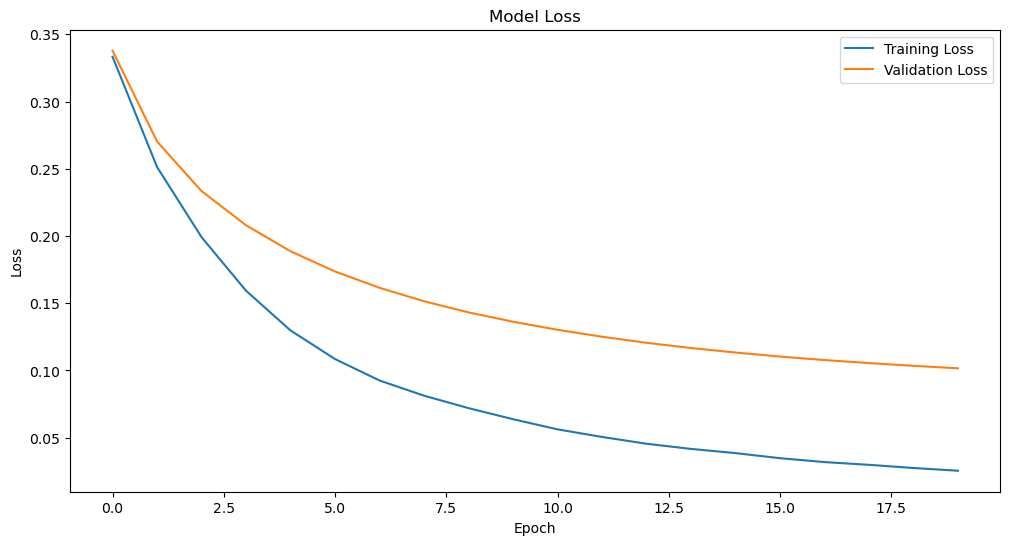

In [20]:
# Plot training and validation metrics
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Analysis of the Model Loss Plot

1. **Training Loss (Blue Line):**
   - The training loss decreases steadily throughout the epochs, indicating that the model is learning effectively on the training data.
   - By the 20th epoch, the training loss approaches near-zero values, suggesting the model has fit the training set well.

2. **Validation Loss (Orange Line):**
   - The validation loss decreases but at a slower rate compared to the training loss.
   - This gap between training and validation loss may suggest some **overfitting** as training loss continues to drop significantly, while validation loss levels off.

---

### Key Observations:
1. **Loss Gap:**
   - A small but noticeable gap exists between the training and validation loss.
   - This is common in deep learning when the model starts overfitting to the training data.

2. **Stability:**
   - Both curves are smooth, indicating no irregularities like unstable gradients or poor learning rates.

3. **Validation Loss Plateau:**
   - The validation loss flattens as the number of epochs increases.
   - This indicates that additional training may not further improve the validation performance.

---

### Recommendations to Address Overfitting:
1. **Regularization Techniques:**
   - Apply **L2 regularization** (weight decay) to the loss function.
   - Add **dropout** layers to the network to reduce overfitting.

2. **Early Stopping:**
   - Stop training when the validation loss stops improving to prevent overfitting.

3. **Data Augmentation:**
   - If applicable, augment training data to improve generalization.

4. **Reduce Model Complexity:**
   - Decrease the number of neurons in hidden layers if the network is overly complex.

---